In [46]:
# modules we'll use

import re  # For preprocessing
import pandas as pd  # For data handling
import spacy
import logging  # Setting up the loggings to monitor gensim
import multiprocessing
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
#mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# read in all our data
# Google Drive's path: /content/drive/MyDrive/Praca Inżynierska/kickstarter/data/spotify.csv
spotify_orig  = pd.read_csv("../data/spotify.csv")

In [6]:
# look at a few rows of the ks_projects file
spotify_orig.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
127976,0.212,1956,0.7370,['Miles Davis'],0.502,277067,0.222,0,3dUML7ng4ScVmf3jqpaWsb,0.000085,1,0.1170,-14.659,1,In Your Own Sweet Way - Rudy Van Gelder Remaster,11,1956,0.0354,111.492
139260,0.970,2012,0.0273,"['Juan Magán', 'Pitbull', 'El Cata']",0.720,197240,0.822,0,4hLEorB47NotMkSLCWmh5e,0.000000,4,0.3080,-4.166,0,Bailando por el Mundo (feat. Pitbull & El Cata),48,2012-05-14,0.0464,129.988
153166,0.721,2008,0.6550,['The Doors'],0.700,130747,0.418,0,6chyadaFmcdgpfSDW31KVj,0.000000,4,0.1950,-11.238,0,People Are Strange - New Stereo Mix,49,2008-01-28,0.0330,119.627
20445,0.875,1928,0.9900,['Ignacio Corsini'],0.520,182840,0.128,0,18MKXumRZphEqOmNo2jEDa,0.918000,0,0.1110,-26.107,1,El Cisne - Remasterizado,0,1928-06-20,0.0498,97.814
136237,0.124,1997,0.1830,['Kenny G'],0.352,199640,0.338,0,0KH4lkNCzPACif93d7u7A9,0.772000,5,0.0876,-12.923,1,Loving You - Edit,37,1997-11-08,0.0345,107.759


In [7]:
# get info about DataFrame columns
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [8]:
# count nullable words
spotify_orig.isnull().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

In [9]:
# Cleaning
# We are lemmatizing and removing the stopwords and non-alphabetic characters for each line

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

# Removes non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in spotify_orig['name'])

In [10]:
# Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.11 mins


In [11]:
# Put the results in a DataFrame to remove missing values and duplicates:

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(63686, 1)

In [14]:
# Bigrams:
# We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
# https://radimrehurek.com/gensim/models/phrases.html
# The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

# As Phrases() takes a list of list of words as input:
sent = [row.split() for row in df_clean['clean']]
# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count=30, progress_per=10000)
# The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed
# for the bigram detection task:
bigram = Phraser(phrases)
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

INFO - 14:09:59: collecting all words and their counts
INFO - 14:09:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:09:59: PROGRESS: at sentence #10000, processed 44856 words and 34048 word types
INFO - 14:09:59: PROGRESS: at sentence #20000, processed 91743 words and 60057 word types
INFO - 14:09:59: PROGRESS: at sentence #30000, processed 138773 words and 84833 word types
INFO - 14:09:59: PROGRESS: at sentence #40000, processed 188044 words and 108179 word types
INFO - 14:09:59: PROGRESS: at sentence #50000, processed 238046 words and 130876 word types
INFO - 14:09:59: PROGRESS: at sentence #60000, processed 286467 words and 152150 word types
INFO - 14:09:59: collected 158700 word types from a corpus of 302854 words (unigram + bigrams) and 63686 sentences
INFO - 14:09:59: using 158700 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:09:59: source_vocab length 158700
INFO - 14:10:01: Phraser built with 256 

In [15]:
# Most Frequent Words:
# Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['remaster', 'live', 'feat', "'", 'be', 'de', 'love', 'op', "'s", 'la']

In [17]:
# Training the model
# Gensim Word2Vec Implementation:
# We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

# I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
#
# Word2Vec():
# In this first step, I set up the parameters of the model one-by-one.
# I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.
#
# .build_vocab():
# Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
# With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus.
# I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model.
# Displaying both allows for a more accurate and an easier management of their influence.
#
# .train():
# Finally, trains the model.
# The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [18]:
# The parameters:
# min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word within a sentence.
# E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled.
# Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses.
# To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
# should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [19]:
# Building the Vocabulary Table:
# Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words,
# and doing some basic counts on them):

t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:20:59: collecting all words and their counts
INFO - 14:20:59: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:20:59: PROGRESS: at sentence #10000, processed 41941 words, keeping 10383 word types
INFO - 14:20:59: PROGRESS: at sentence #20000, processed 85486 words, keeping 16279 word types
INFO - 14:20:59: PROGRESS: at sentence #30000, processed 129453 words, keeping 21549 word types
INFO - 14:21:00: PROGRESS: at sentence #40000, processed 175438 words, keeping 26140 word types
INFO - 14:21:00: PROGRESS: at sentence #50000, processed 222104 words, keeping 30538 word types
INFO - 14:21:00: PROGRESS: at sentence #60000, processed 267925 words, keeping 34292 word types
INFO - 14:21:00: collected 35270 word types from a corpus of 283552 raw words and 63686 sentences
INFO - 14:21:00: Loading a fresh vocabulary
INFO - 14:21:00: min_count=20 retains 2135 unique words (6% of original 35270, drops 33135)
INFO - 14:21:00: min_count=20 leaves 197899 word corpu

Time to build vocab: 0.03 mins


In [20]:
# Training of the model:

# Parameters of the training:
# total_examples = int - Count of sentences;
# epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:22:53: training model with 7 workers on 2135 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 14:22:54: EPOCH 1 - PROGRESS: at 64.54% examples, 51079 words/s, in_qsize 0, out_qsize 0
INFO - 14:22:55: worker thread finished; awaiting finish of 6 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 5 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 4 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 3 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 2 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 1 more threads
INFO - 14:22:55: worker thread finished; awaiting finish of 0 more threads
INFO - 14:22:55: EPOCH - 1 : training on 283552 raw words (80770 effective words) took 1.4s, 56239 effective words/s
INFO - 14:22:56: EPOCH 2 - PROGRESS: at 81.42% examples, 64705 words/s, in_qsize 0, out_qsize 0
INFO - 14:22:56: worker thread f

Time to train the model: 0.55 mins


In [21]:
# As we do not plan to train the model any further, we are calling init_sims(),
# which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

INFO - 14:24:37: precomputing L2-norms of word weight vectors


In [22]:
# Exploring the model
# Most similar to:
# Here, we will ask our model to find the word most similar to 'love'

w2v_model.wv.most_similar(positive=["love"])

[('everybody', 0.972824215888977),
 ('look', 0.968979001045227),
 ('will_not', 0.9680449962615967),
 ('believe', 0.96721351146698),
 ('anymore', 0.9659347534179688),
 ('help', 0.9656952619552612),
 ('good', 0.9648260474205017),
 ('let', 0.9637019634246826),
 ('not', 0.9636774063110352),
 ('know', 0.9620110988616943)]

In [26]:
# Similarities:
# Here, we will see how similar are two words to each other :

w2v_model.wv.similarity('love', 'like')

0.94195759708451

In [32]:
w2v_model.wv.similarity('love', 'wood')

# Odd-One-Out:
# Here, we ask our model to give us the word that does not belong to the list!

w2v_model.wv.doesnt_match(['love', 'like', 'tree'])

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'tree'

In [36]:
w2v_model.wv.doesnt_match(['moon', 'plant', 'rose'])

WARNING - 14:34:49: vectors for words {'plant'} are not present in the model, ignoring these words
C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'moon'

In [45]:
# Analogy difference:

# Which word is to woman as homer is to marge?

w2v_model.wv.most_similar(positive=["cold", "hate"], negative=["love"], topn=3)
w2v_model.wv.most_similar(positive=["joy", "door"], negative=["house"], topn=3)

[('tune', 0.7672429084777832),
 ('bol', 0.7661900520324707),
 ('gham', 0.7498449087142944)]

In [47]:
# t-SNE visualizations:
# t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the
# underlying relationships between vectors in a lower-dimensional space.
# Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

sns.set_style("darkgrid")
%matplotlib inline

In [54]:
# Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot
# interesting patterns.
# For that we are going to use t-SNE implementation from scikit-learn.
# To make the visualizations more relevant, we will look at the relationships between a query word (in red),
# its most similar words in the model (in blue), and other words from the vocabulary (in green).

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

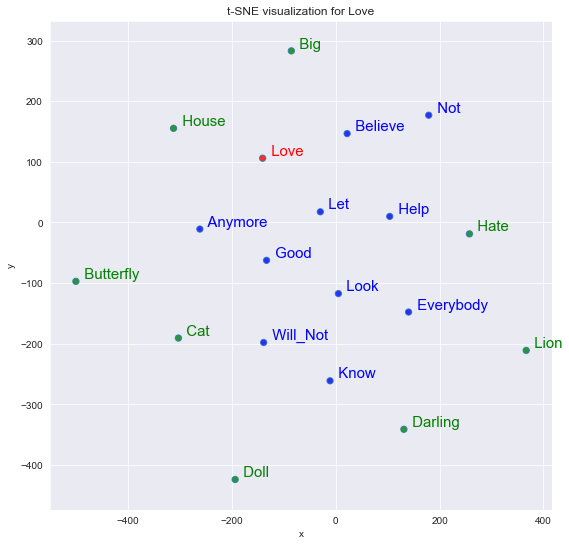

In [55]:
# 10 Most similar words vs. 8 Random words:
# Let's compare where the vector representation of 'love', its 10 most similar words from the model, ' \
# 'as well as 8 random ones, lies in a 2D graph:

tsnescatterplot(w2v_model, 'love', ['darling', 'hate', 'house', 'cat', 'butterfly', 'lion', 'big', 'doll'])

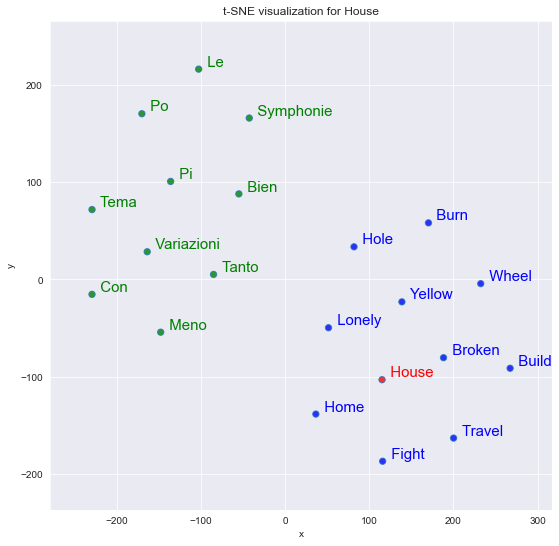

In [56]:
# 10 Most similar words vs. 10 Most dissimilar
# This time, let's compare where the vector representation of 'house' and her 10 most similar words from the model lies
# compare to the vector representation of the 10 most dissimilar words to 'house':

tsnescatterplot(w2v_model, 'house', [i[0] for i in w2v_model.wv.most_similar(negative=["house"])])
